In [1]:
%pip install seaborn

from PIL import Image
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

Note: you may need to restart the kernel to use updated packages.


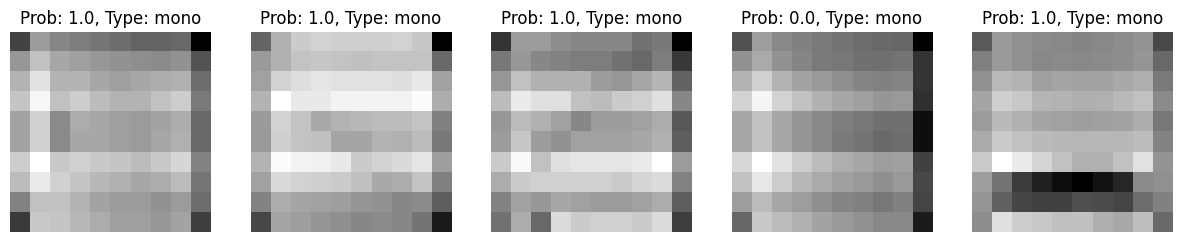

In [2]:
def load_dataset(fname=None, new_size=(10, 10)):
    if fname is None:
        # Assume we are in the utils folder and get the absolute path to the
        # parent directory.
        base_dir = os.getcwd()
        fname = os.path.join(base_dir, '../elpv-dataset/labels.csv')

    data = np.genfromtxt(fname, dtype=['|S19', '<f8', '|S4'], names=[
                         'path', 'probability', 'type'])
    image_fnames = np.char.decode(data['path'])
    probs = data['probability']
    types = np.char.decode(data['type'])

    def load_cell_image(fname):
        with Image.open(fname) as image:
            image = image.convert('L')  # Convert to grayscale
            image = image.resize(new_size, Image.Resampling.LANCZOS)  # Resize the image
            return np.asarray(image)

    dir = os.path.dirname(fname)

    images = np.array([load_cell_image(os.path.join(dir, fn))
                       for fn in image_fnames])

    return images, probs, types

images, proba, types = load_dataset(new_size=(10, 10))  


N = 5
plt.figure(figsize=(15, 10))
for i in range(N):
    ax = plt.subplot(1, N, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(f"Prob: {proba[i]}, Type: {types[i]}")
    plt.axis('off')
plt.show()



In [3]:
# Flatten the images for ML algorithms
X = images.reshape((images.shape[0], -1))
y = (proba > 0.5).astype(int)  # Convert probabilities to binary labels for classification

In [5]:
# 将类型编码为数字
type_encoder = LabelEncoder()
types_encoded = type_encoder.fit_transform(types)
# Split the data
X_train, X_test, y_train, y_test, types_train, types_test = train_test_split(X, y, types_encoded, test_size=0.25, random_state=42)

# Filter out 'mono' and 'poly' samples for separate processing
# 假设 'mono' 编码为 0，'poly' 编码为 1
X_train_mono = X_train[types_train == 0]
y_train_mono = y_train[types_train == 0]
X_test_mono = X_test[types_test == 0]
y_test_mono = y_test[types_test == 0]

X_train_poly = X_train[types_train == 1]
y_train_poly = y_train[types_train == 1]
X_test_poly = X_test[types_test == 1]
y_test_poly = y_test[types_test == 1]

In [6]:
# Create a pipeline with PCA and a classifier
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=150)),  # Adjust the number of components
    ('classifier', RandomForestClassifier(random_state=42))
])

# Parameters for grid search
param_grid = {
    'pca__n_components': [50, 100, 150],
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [5, 10, None]
}

# Create and train a pipeline for 'mono' samples
pipe_mono = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=50)),
    ('classifier', RandomForestClassifier(random_state=42))
])
pipe_mono.fit(X_train_mono, y_train_mono)

# Predictions and evaluation for 'mono'
y_pred_mono = pipe_mono.predict(X_test_mono)

# Create and train a pipeline for 'poly' samples
pipe_poly = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=50)),
    ('classifier', RandomForestClassifier(random_state=42))
])
pipe_poly.fit(X_train_poly, y_train_poly)

# Predictions and evaluation for 'poly'
y_pred_poly = pipe_poly.predict(X_test_poly)

In [7]:
# Grid search with cross-validation
grid_search = GridSearchCV(pipe, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# Predictions
y_pred = best_model.predict(X_test)

# 计算准确度
accuracy = accuracy_score(y_test, y_pred)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File 

              precision    recall  f1-score   support

           0       0.81      0.93      0.87       445
           1       0.79      0.53      0.64       211

    accuracy                           0.80       656
   macro avg       0.80      0.73      0.75       656
weighted avg       0.80      0.80      0.79       656

[[416  29]
 [ 99 112]]


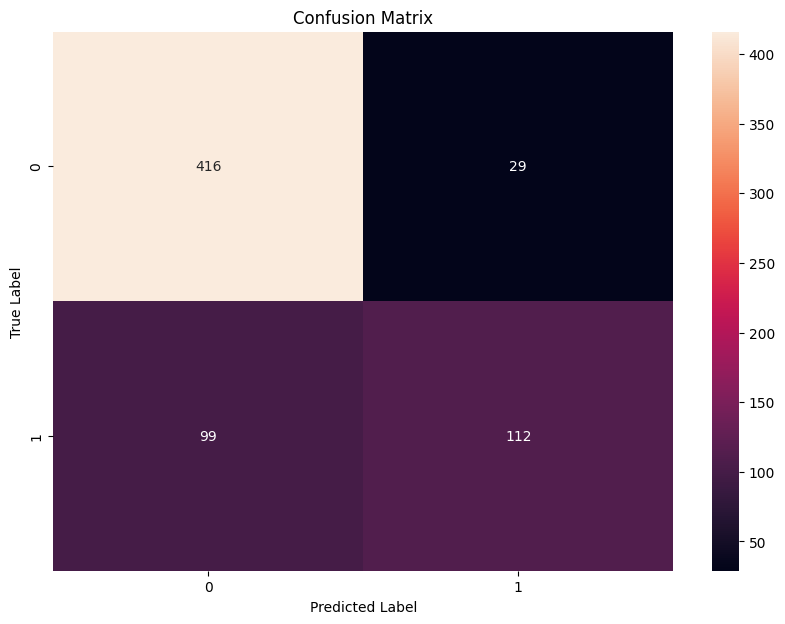

Accuracy on Test Set: 0.80
Classification Report for Mono:
              precision    recall  f1-score   support

           0       0.82      0.91      0.87       173
           1       0.81      0.66      0.73       100

    accuracy                           0.82       273
   macro avg       0.82      0.79      0.80       273
weighted avg       0.82      0.82      0.82       273

Confusion Matrix for Mono:
[[158  15]
 [ 34  66]]
Accuracy for Mono: 82.05%

Classification Report for Poly:
              precision    recall  f1-score   support

           0       0.81      0.94      0.87       272
           1       0.77      0.46      0.58       111

    accuracy                           0.80       383
   macro avg       0.79      0.70      0.72       383
weighted avg       0.80      0.80      0.79       383

Confusion Matrix for Poly:
[[257  15]
 [ 60  51]]
Accuracy for Poly: 80.42%


In [8]:
# Evaluation
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Plotting confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 打印准确度
print(f"Accuracy on Test Set: {accuracy:.2f}")

print("Classification Report for Mono:")
print(classification_report(y_test_mono, y_pred_mono))
print("Confusion Matrix for Mono:")
print(confusion_matrix(y_test_mono, y_pred_mono))
print("Accuracy for Mono: {:.2f}%".format(100 * accuracy_score(y_test_mono, y_pred_mono)))


print("\nClassification Report for Poly:")
print(classification_report(y_test_poly, y_pred_poly))
print("Confusion Matrix for Poly:")
print(confusion_matrix(y_test_poly, y_pred_poly))
print("Accuracy for Poly: {:.2f}%".format(100 * accuracy_score(y_test_poly, y_pred_poly)))